In [36]:
# https://www.youtube.com/watch?v=4yOcsWg-7g8&t=4s

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2 
from PIL import Image
from extract_bb import show_img_bb, extract_bb

device = 'cuda' if torch.cuda.is_available() else 'cpu'

[[174 265 438 657]]


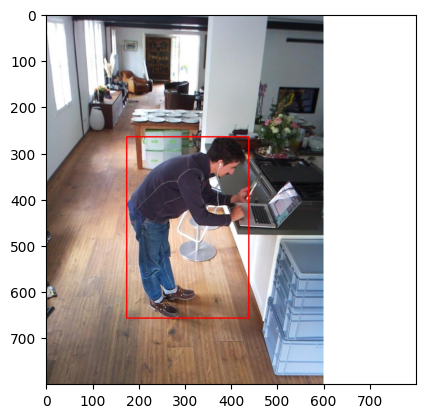

In [37]:
image_path = "04Training_Data2/train/images/T1D0pa0dataset0.jpg"
label_path = "04Training_Data2/train/labels/T1D0pa0dataset0.txt"

img = cv2.imread(image_path)

# Resize to 800 by 800 for vgg
img = cv2.resize(img, dsize=(800,800), interpolation=cv2.INTER_CUBIC)
x_min, y_min, x_max, y_max = extract_bb(label_path, image_path, 800)
bbox0 = [[int(x_min), int(y_min), int(x_max), int(y_max)]]
bbox = np.array(bbox0)
print(bbox)

show_img_bb(label_path, image_path, size = 800)

In [38]:
# Change bounding box coordinates



In [39]:
# Step 1: Use VGG 16 (or other image classifiers e.g. Resnet50) to extract features from image
model = torchvision.models.vgg16(pretrained=True).to(device)
# Review layers of VGG16
fe = list(model.features)
print(len(fe))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


31


In [40]:
# Step 2 SUBSAMPLING: we have 3x800x800 (e.g.) as input. We want to perform subsampling (reduce size, increase depth)
# s.t. we get a 512x50x50, thus, we use all the layers up until that point in vgg
dummy_img = torch.zeros((1,3,800,800)).float()

req_features = []
k = dummy_img.clone().to(device)
for i in fe:
    k = i(k)
    # print("k is",k.shape[2])
    if k.shape[2] < 50: #800//16 = 50
        break
    req_features.append(i)
    out_channels = k.size()[1]

print(len(req_features))    
print(out_channels)
# Until layer 30 the feature size is is larger than 50

# Convert the layers into a sequential module
faster_rcnn_fe_extractor = nn.Sequential(*req_features)

30
512


In [41]:
# Step 3, pass image to extracted VGG layers
transform = transforms.Compose([transforms.ToTensor()])
imgTensor = transform(img).to(device)
imgTensor = imgTensor.unsqueeze(0)
print(imgTensor.shape)
out_map = faster_rcnn_fe_extractor(imgTensor)
print(out_map.size())


torch.Size([1, 3, 800, 800])
torch.Size([1, 512, 50, 50])


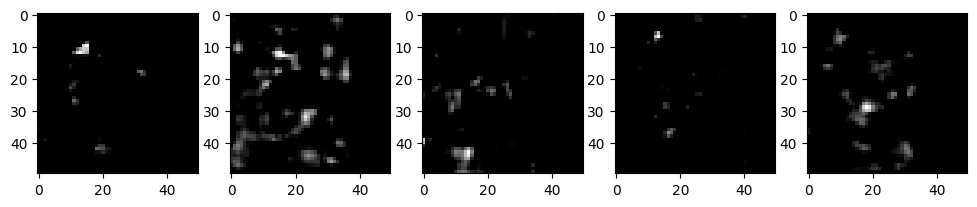

In [42]:
# Step 4 Visualize results (we just take a look at the first 5)
# We have 512 
imgArray=out_map.data.cpu().numpy().squeeze(0)
fig = plt.figure(figsize=(12,4))
for i in range(5):
    fig.add_subplot(1,5,i+1)
    plt.imshow(imgArray[i], cmap='gray')
plt.show()


50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]
(2500, 2)
[[  8.   8.]
 [ 24.   8.]
 [ 40.   8.]
 ...
 [760. 792.]
 [776. 792.]
 [792. 792.]]


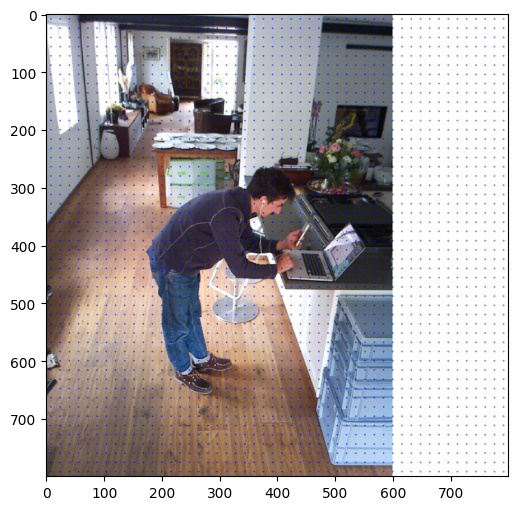

In [43]:
# Step 5: Generate Anchor Boxes on the input image
#  x, y intervals to generate anchor box center
fe_size = (800//16)
ctr_x = np.arange(16, (fe_size+1) * 16, 16)
ctr_y = np.arange(16, (fe_size+1) * 16, 16)

print(len(ctr_x), ctr_x)

# coordinates of the 2500 cetner points to generate anchor boxes
index = 0
ctr = np.zeros((2500, 2))
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[x] - 8
        ctr[index, 0] = ctr_y[y] - 8
        index += 1
print(ctr.shape)
print(ctr)


# Display the 2500 anchors
img_clone = np.copy(img)
plt.figure(figsize=(9,6))
for i in range(ctr.shape[0]):
    cv2.circle(img_clone, (int(ctr[i][0]), int(ctr[i][1])), radius=1, color=(255,0,0), thickness=1)
img_clone = cv2.cvtColor(img_clone, cv2.COLOR_BGR2RGB)
plt.imshow(img_clone)
plt.show()

(22500, 4)


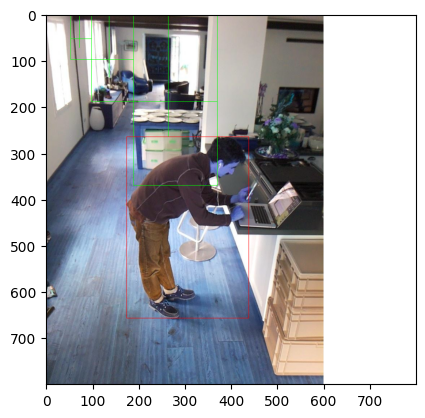

In [44]:
# for each of the 2500 anchros, generate 9 anchor boxes
# 2500*9 = 22500 anchor boxes

ratios = [0.5, 1, 2]
scales = [8,16,32]
sub_sample = 16
anchor_boxes = np.zeros(((fe_size * fe_size * 9), 4))
index = 0
for c in ctr:
    ctr_y, ctr_x = c
    for i in range(len(ratios)):
        for j in range(len(scales)):
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ratios[i])
            anchor_boxes[index, 0] = ctr_y - h /2
            anchor_boxes[index, 1] = ctr_x - w /2
            anchor_boxes[index, 2] = ctr_y + h /2
            anchor_boxes[index, 3] = ctr_x + w /2
            index += 1

print(anchor_boxes.shape)


img_clone = np.copy(img)
# We only show 9 anchor boxes. but have 22500
for i in range(0, 9):
    x0 = int(anchor_boxes[i][1])
    y0 = int(anchor_boxes[i][0])
    x1 = x0 = int(anchor_boxes[i][3])
    y1 = x0 = int(anchor_boxes[i][2])
    cv2.rectangle(img_clone, (x0,y0), (x1, y1), color= (0, 255,0), thickness=1)

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0],bbox[i][1]), (bbox[i][2], bbox[i][3]), color= (255, 0,0), thickness=1)

plt.imshow(img_clone)
plt.show()

In [45]:
# Ignore cross-boundary anchor boxes
# Valid Anchor boxes with y1, x1 > 0 and y2, x2 <= 800

index_inside = np.where(
    (anchor_boxes[:, 0] > 0) &
    (anchor_boxes[:, 1] > 0) &
    (anchor_boxes[:, 2] > 800) &
    (anchor_boxes[:, 3] > 800)
)[0]
print(index_inside.shape)
valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(1010,)
(1010, 4)


In [46]:
# Step 6: Calculate IoU of the valid 
ious = np.empty((len(valid_anchor_boxes), 2), dtype=np.float32)
ious.fill(0)

for num1, i in enumerate(valid_anchor_boxes):
    ya1, xa1, ya2, xa2 = i
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        xb1, yb1, xb2, yb2 = j
        bbox_area = (yb2-yb1) * (xb2-xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        
        # print(inter_x1, inter_x2, inter_y1, inter_y2)
        
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area + bbox_area - iter_area)
        else:
            iou = 0
            
        ious[num1, num2] = iou
        # print(ious[num1, num2])
print(ious.shape) 
print(ious)


(1010, 2)
[[0.17474811 0.        ]
 [0.1590186  0.        ]
 [0.14370476 0.        ]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]


In [47]:
# What anchor box has max iou with the grount truth bbox
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[0 0]
[0.17474811 0.        ]
[   0    0    1 ... 1007 1008 1009]


In [48]:
# What ground truth bbox is associated with each anchor box
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)
max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

(1010,)
[0 0 0 ... 0 0 0]
[0.17474811 0.1590186  0.14370476 ... 0.         0.         0.        ]


In [49]:
label = np.empty((len(index_inside, ), ), dtype=np.int32)
label.fill(-1)
print(label.shape)

# Use iou to assing 1 (objects) to two kind of anchors
# a) the anchors with the highest iou overlap with a ground-truth-box
# b) An anchor that has an IoU overlap higher than 0.7 with ground-truth-boxes

# Assing 0 background to an anchor if its IoU ratio i slower than 0.3 for all ground truth boxes
pos_iou_threshold = 0.7
neg_iou_threshold = 0.3
label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0

(1010,)


In [50]:
# Step 7: Minibatch training with n = 256
# with -1 as ignore index
n_samples = 256
pos_ratio = 0.5
n_pos = pos_ratio * n_samples

pos_index = np.where(label == 1)[0]
if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index)- n_pos), replace=False)
    label[disable_index] = - 1

n_neg = n_samples * np.sum(label==1)
neg_index = np.where(label==0)[0]
if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index)- n_neg), replace=False)
    label[disable_index] = - 1

In [51]:
# For each valid anchor box, find groundtruth object which has max iou
print(bbox)
print(argmax_ious)
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)

# Valid anchor boxes h,x, cx,cy
height = valid_anchor_boxes[0:,2] - valid_anchor_boxes[:, 0]
width = valid_anchor_boxes[0:,3] - valid_anchor_boxes[:, 1]
ctr_y = height = valid_anchor_boxes[0:,0] + 0.5 * height
ctr_x = valid_anchor_boxes[0:,1] + 0.5 * width

# Valid anchor box, max iou, bbox, h, w, cx, cy
base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_ctry = max_iou_bbox[0:, 0] + 0.5 * base_height
base_ctrx = max_iou_bbox[0:, 1] + 0.5 * base_width

# Valid anchors boxes
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)
dy = (base_ctry - ctr_y)
dx = (base_ctrx - ctr_x)
dh = np.log(base_height/height)
dw = np.log(base_width - width)
anchor_locs = np.vstack((dy,dx,dh,dw)).transpose()
print(anchor_locs.shape)


[[174 265 438 657]]
[0 0 0 ... 0 0 0]
(1010, 4)
(1010, 4)


/var/folders/f2/rzy3hysn2w5bm0pr6_tw028m0000gn/T/ipykernel_48968/1490515267.py:26: RuntimeWarning: invalid value encountered in log
  dw = np.log(base_width - width)


In [52]:
anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)

(22500,)
(22500, 4)


In [53]:
# RPN - Region Proposal Network 

in_channels = 512
mid_chanels = 512
n_anchors = 9

conv1 = nn.Conv2d(in_channels, mid_chanels, 3,1,1).to(device)
conv1.weight.data.normal_(0,0.01)
conv1.bias.data.zero_()

reg_layer = nn.Conv2d(mid_chanels, n_anchors * 4, 1,1,0).to(device)
reg_layer.weight.data.normal_(0,0.01)
reg_layer.bias.data.zero_()

cls_layer = nn.Conv2d(mid_chanels, n_anchors*2, 1, 1, 0).to(device)
cls_layer.weight.data.normal_(0,0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [54]:
x = conv1(out_map).to(device) # out_map = faster_rcnn_fe_extractor(imgTensor)
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)

print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


In [55]:
pred_anchor_locs = pred_anchor_locs.permute(0,2,3,1).contiguous().view(1,-1,4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0,2,3,1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1,50,50,9,2)[:,:,:,:,1].contiguous().view(1,-1)
print(objectness_score.shape)

pred_cls_scores = pred_cls_scores.view(1,-1,2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


In [56]:
print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)


# RPN Loss



torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)


In [58]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape, rpn_score.shape, gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


In [59]:
# For classification we use cross entropy loss
rpn_cls_loss = F.cross_entropy(rpn_score,gt_rpn_score.long().to(device), ignore_index = -1)
print(rpn_cls_loss)

tensor(nan, grad_fn=<NllLossBackward0>)
